In [2]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 124.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge dash

Channels:
 - conda-forge
Platform: linux-64
doneecting package metadata (repodata.json): - 
doneing environment: | 


==> WARNING: A newer version of conda exists. <==
    current version: 25.1.0
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - dash


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.1.31  |       hbcca054_0         154 KB  conda-forge
    certifi-2025.1.31          |     pyhd8ed1ab_0         159 KB  conda-forge
    click-8.1.8                |     pyh707e725_0          83 KB  conda-forge
    dash-3.0.2                 |     pyhd8ed1ab_0         5.3 MB  conda-forge
    flask-3.1.0                |     pyhd8ed1ab_1          80 KB  conda-forge
    itsdangerous-2.2.0         |     pyhd8ed1ab_1          19 KB 

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3271 entries, 0 to 3270
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3271 non-null   object 
 1   MinTemp        3271 non-null   float64
 2   MaxTemp        3271 non-null   float64
 3   Rainfall       3271 non-null   float64
 4   Evaporation    3271 non-null   float64
 5   Sunshine       3271 non-null   float64
 6   WindGustDir    3271 non-null   object 
 7   WindGustSpeed  3271 non-null   int64  
 8   WindDir9am     3271 non-null   object 
 9   WindDir3pm     3271 non-null   object 
 10  WindSpeed9am   3271 non-null   int64  
 11  WindSpeed3pm   3271 non-null   int64  
 12  Humidity9am    3271 non-null   int64  
 13  Humidity3pm    3271 non-null   int64  
 14  Pressure9am    3271 non-null   float64
 15  Pressure3pm    3271 non-null   float64
 16  Cloud9am       3271 non-null   int64  
 17  Cloud3pm       3271 non-null   in

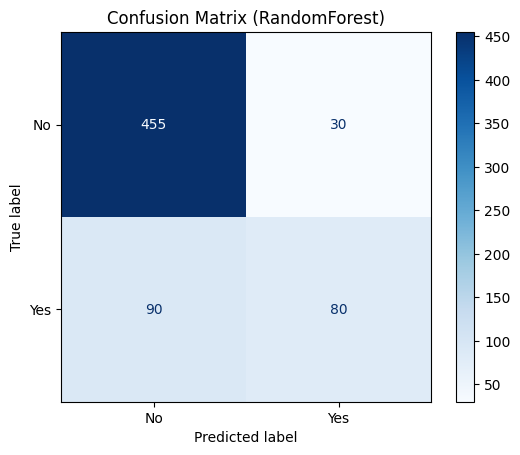


Top 20 Feature Importances (RandomForest):


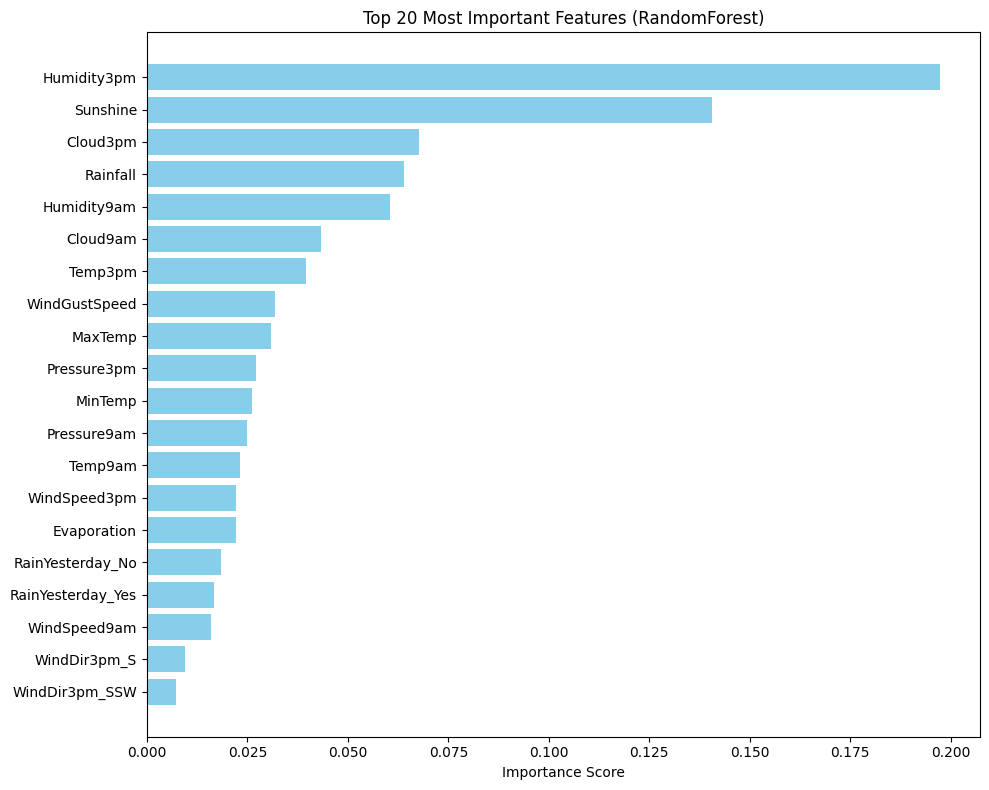


Most important feature (RandomForest): Humidity3pm

--- Training LogisticRegression ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters found (LogisticRegression):  {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score (LogisticRegression): 0.8456
Test set score (LogisticRegression): 0.8229

Classification Report (LogisticRegression):
              precision    recall  f1-score   support

          No       0.86      0.91      0.88       485
         Yes       0.69      0.58      0.63       170

    accuracy                           0.82       655
   macro avg       0.77      0.74      0.76       655
weighted avg       0.82      0.82      0.82       655


Confusion Matrix (LogisticRegression):


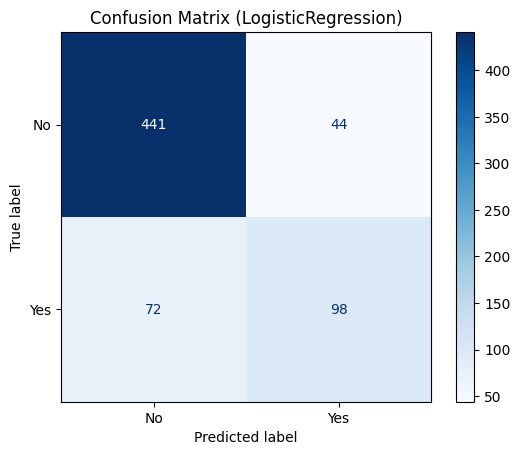


--- Model Comparison ---
RandomForest Test Accuracy: 0.8168
LogisticRegression Test Accuracy: 0.8229
RandomForest True Positive Rate (Recall for 'Yes'): 0.47058823529411764
LogisticRegression True Positive Rate (Recall for 'Yes'): 0.5764705882352941

Comparison Summary:
* Accuracy: RandomForest (81.68%) vs LogisticRegression (82.29%)
* Correct Predictions (Test Set - RandomForest): 535
* Correct Predictions (Test Set - LogisticRegression): 539
* True Positive Rate ('Yes' Recall): RandomForest (47.06%) vs LogisticRegression (57.65%)


In [6]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


# import dash # Not needed for notebook execution
# import more_itertools # Unused import
# from dash import dcc # Not needed for notebook execution
# from dash import html # Not needed for notebook execution
# from dash.dependencies import Input, Output # Not needed for notebook execution
import pandas as pd
# import plotly.graph_objs as go # Unused import
import plotly.express as px
import matplotlib.pyplot as plt # Added for confusion matrix display
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns # Added for heatmap confusion matrix
from sklearn.impute import SimpleImputer # Added for Imputation

# Load the data using pandas
# --- Loading the correct weather dataset ---
url_weather = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillUp/labs/ML-FinalAssignment/Weather_Data.csv"
df = pd.read_csv(url_weather)


# --- Start of Notebook Logic ---

print("Initial Data Info:")
df.info()
print("\nInitial Data Head:")
print(df.head())
print("\nAvailable columns after loading:")
print(df.columns) # Verify column names

# --- MODIFICATION: Handle Missing Data using Imputation ---
# Skip dropna() as it removes too much data or causes errors
print("\nSkipping df.dropna() - will use imputation in pipeline.")
# df = df.dropna() # <-- Keep this commented out


# Rename columns for clarity (predicting today's rain based on yesterday)
# Check if columns exist before renaming
if 'RainToday' in df.columns and 'RainTomorrow' in df.columns:
    df = df.rename(columns={'RainToday': 'RainYesterday',
                            'RainTomorrow': 'RainToday'
                            })
    print("\nRenamed 'RainToday'->'RainYesterday' and 'RainTomorrow'->'RainToday'")
else:
    print("Warning: 'RainToday' or 'RainTomorrow' columns not found for renaming.")


# --- REMOVED Location Filtering Block ---
# Since 'Location' column is missing in the loaded CSV, we skip filtering.
# The model will be trained on all available data after cleaning.
print("\nSkipping location filtering as 'Location' column is missing in the source CSV.")


# --- Feature Engineering: Season ---

# Check if 'Date' column exists and convert
if 'Date' in df.columns:
    # Convert the 'Date' column to datetime format
    df['Date'] = pd.to_datetime(df['Date']) # Convert to datetime objects

    # Define a function to map dates to seasons (Southern Hemisphere)
    def date_to_season(date):
        month = date.month
        # Southern Hemisphere Seasons
        if month in [12, 1, 2]:
            return 'Summer'
        elif month in [3, 4, 5]:
            return 'Autumn'
        elif month in [6, 7, 8]:
            return 'Winter'
        elif month in [9, 10, 11]:
            return 'Spring'

    # Apply the function to the 'Date' column
    df['Season'] = df['Date'].apply(date_to_season) # Create Season column

    # Drop the original Date column
    df = df.drop(columns=['Date']) # Drop original Date column

    print("\nAdded 'Season' feature and dropped 'Date' column.")
    print("DataFrame head after adding Season:")
    print(df.head())
else:
    print("Warning: 'Date' column not found. Cannot create 'Season' feature.")


# --- Handle Remaining Missing Values Before Splitting (Crucial for Target) ---
# Specifically check the target variable 'RainToday'
if 'RainToday' in df.columns:
    print(f"\nMissing values in target 'RainToday' before drop: {df['RainToday'].isnull().sum()}")
    df.dropna(subset=['RainToday'], inplace=True) # Drop rows where target is missing
    print(f"Missing values in target 'RainToday' after drop: {df['RainToday'].isnull().sum()}")
    print(f"DataFrame shape after dropping rows with missing target: {df.shape}")
else:
    # If 'RainTomorrow' wasn't renamed, maybe the target is still 'RainTomorrow'? Check that.
    if 'RainTomorrow' in df.columns:
         print("Target column seems to be 'RainTomorrow'. Checking NAs...")
         print(f"\nMissing values in target 'RainTomorrow' before drop: {df['RainTomorrow'].isnull().sum()}")
         df.dropna(subset=['RainTomorrow'], inplace=True)
         print(f"Missing values in target 'RainTomorrow' after drop: {df['RainTomorrow'].isnull().sum()}")
         print(f"DataFrame shape after dropping rows with missing target: {df.shape}")
         # Define target using the original name if renaming failed
         y = df['RainTomorrow']
         X = df.drop(columns='RainTomorrow', axis=1)
    else:
        raise SystemExit("Stopping execution: Target column ('RainToday' or 'RainTomorrow') not found.")

# Check if DataFrame is empty after dropping rows with missing target
if df.empty:
    raise SystemExit("Stopping execution: DataFrame is empty after dropping rows with missing target.")

# Define X and y if not defined in the exception block above
if 'X' not in locals() or 'y' not in locals():
    X = df.drop(columns='RainToday', axis=1) # Features: all columns except the target
    y = df['RainToday'] # Target: 'RainToday' column


# --- Model Building ---

# Exercise 3: How balanced are the classes?
print("\nClass distribution for Target Variable:")
print(y.value_counts())

# Exercise 4: What can you conclude from these counts?
print("\nExercise 4 Observations:")
target_counts = y.value_counts()
total_counts = len(y)
if total_counts > 0:
    # Assuming target classes are 'No' and 'Yes'
    no_pct = (target_counts.get('No', 0) / total_counts) * 100
    yes_pct = (target_counts.get('Yes', 0) / total_counts) * 100
    print(f"- Percentage of days with 'No': {no_pct:.2f}%")
    print(f"- Percentage of days with 'Yes': {yes_pct:.2f}%")
    print(f"- Accuracy if always predicting 'No': {no_pct:.2f}%")
    print("- Is the dataset balanced? No, the 'No' class is significantly more frequent.")
    print("- Next steps: Use stratification in train/test split, consider class weighting or resampling if needed, use metrics beyond accuracy (like F1, recall for 'Yes').")
else:
    print("- DataFrame is empty, cannot calculate class balance.")


# Exercise 5: Split data into training and test sets, ensuring target stratification
min_class_count = y.value_counts().min() if not y.empty else 0
stratify_param = None
if total_counts == 0:
     raise SystemExit("Stopping execution: Cannot split empty DataFrame.")
elif min_class_count < 2:
    print(f"\nWarning: The least populated class has only {min_class_count} member(s). Stratification requires at least 2. Proceeding without stratification.")
else:
    stratify_param = y # Use stratification

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=stratify_param, # Use stratification if possible
    random_state=42
)
print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


# Exercise 6: Automatically detect numerical and categorical columns
# Ensure X_train is not empty before selecting dtypes
if X_train.empty:
    raise SystemExit("Stopping execution: X_train is empty after splitting.")

numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("\nNumeric Features:", numeric_features)
print("Categorical Features:", categorical_features) # Note: 'Location' will be missing here


# Define separate transformers for both feature types (WITH IMPUTATION)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numeric values
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]) # sparse_output=False can sometimes help


# Exercise 7: Combine the transformers into a single preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), # Apply numeric transformer to numeric features
        ('cat', categorical_transformer, categorical_features) # Apply categorical transformer to categorical features
    ],
    remainder='passthrough' # Keep any columns not specified
)


# Exercise 8: Create a pipeline by combining the preprocessing with a Random Forest classifier
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor), # Preprocessing step
    ('classifier', RandomForestClassifier(random_state=42)) # Classifier step named 'classifier'
])


# Define a parameter grid for RandomForest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}


# Select a cross-validation method, ensuring target stratification
min_class_count_train = y_train.value_counts().min() if not y_train.empty else 0
n_splits_cv = 5
if min_class_count_train < n_splits_cv:
     print(f"\nWarning: The least populated class in y_train has only {min_class_count_train} member(s). StratifiedKFold requires at least n_splits={n_splits_cv} members. Using regular KFold with {n_splits_cv} splits.")
     cv = n_splits_cv # Use standard KFold integer
else:
     cv = StratifiedKFold(n_splits=n_splits_cv, shuffle=True, random_state=42) # Use StratifiedKFold


# Exercise 9: Instantiate and fit GridSearchCV to the pipeline (Random Forest)
print("\n--- Training RandomForestClassifier ---")
grid_search_rf = GridSearchCV(
    pipeline_rf,          # The pipeline object
    param_grid_rf,        # The parameter grid for RF
    cv=cv,                # Cross-validation strategy
    scoring='accuracy',   # Scoring metric
    verbose=1,            # Verbosity level
    n_jobs=-1             # Use all available CPU cores
)
grid_search_rf.fit(X_train, y_train) # Fit to training data


# Print the best parameters and best crossvalidation score for RF
print("\nBest parameters found (RandomForest): ", grid_search_rf.best_params_)
print("Best cross-validation score (RandomForest): {:.4f}".format(grid_search_rf.best_score_))


# Exercise 10: Display Random Forest model's estimated score on the test set
test_score_rf = grid_search_rf.score(X_test, y_test) # Score on test data
print("Test set score (RandomForest): {:.4f}".format(test_score_rf))


# Exercise 11: Get the model predictions from the grid search estimator (RF) on the unseen data
y_pred_rf = grid_search_rf.predict(X_test) # Predict on test data


# Exercise 12: Print the classification report for RF
print("\nClassification Report (RandomForest):")
print(classification_report(y_test, y_pred_rf, zero_division=0))


# Exercise 13: Plot the confusion matrix for RF
print("\nConfusion Matrix (RandomForest):")
try:
    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    disp_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=grid_search_rf.classes_)
    disp_rf.plot(cmap='Blues')
    plt.title('Confusion Matrix (RandomForest)')
    plt.show()
except Exception as e:
    print(f"Could not plot confusion matrix for RF: {e}")


# --- Exercise 14: Extract Feature Importances (Random Forest) ---
try:
    best_rf_pipeline = grid_search_rf.best_estimator_
    best_rf_model = best_rf_pipeline.named_steps['classifier']
    feature_importances = best_rf_model.feature_importances_

    # Get feature names after preprocessing
    preprocessor_fitted = best_rf_pipeline.named_steps['preprocessor']
    # Get OHE names if categorical features exist
    ohe_feature_names = []
    if categorical_features: # Check if list is not empty
        try:
             # Check if 'cat' transformer exists (it might be dropped if categorical_features is empty)
             cat_transformer = preprocessor_fitted.named_transformers_['cat']
             ohe_feature_names = cat_transformer.named_steps['onehot'] \
                                     .get_feature_names_out(categorical_features)
        except KeyError:
             print("Categorical transformer ('cat') not found in preprocessor, likely no categorical features were processed.")


    # Combine numeric and OHE categorical feature names
    # Ensure numeric_features only contains features actually processed by 'num'
    processed_numeric_features = [f for f in numeric_features if f in X_train.columns] # Filter just in case
    feature_names = processed_numeric_features + list(ohe_feature_names)

    # Adjust length if feature_importances doesn't match feature_names
    if len(feature_importances) != len(feature_names):
         print(f"Warning: Mismatch between number of importances ({len(feature_importances)}) and feature names ({len(feature_names)}). Skipping importance plot.")
    else:
        importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importances
                                     }).sort_values(by='Importance', ascending=False)

        # Plotting Top N Feature Importances
        N = 20
        top_features = importance_df.head(N)

        print(f"\nTop {N} Feature Importances (RandomForest):")
        plt.figure(figsize=(10, 8))
        plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
        plt.gca().invert_yaxis()
        plt.title(f'Top {N} Most Important Features (RandomForest)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()

        if not importance_df.empty:
            most_important_feature = importance_df.iloc[0]['Feature']
            print(f"\nMost important feature (RandomForest): {most_important_feature}")
        else:
            print("\nCould not determine feature importances.")

except Exception as e:
    print(f"Could not calculate or plot feature importances for RF: {e}")


# --- Exercise 15: Try Logistic Regression ---
print("\n--- Training LogisticRegression ---")

# Create a *new* pipeline for Logistic Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000)) # Increased max_iter
])

# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'classifier__solver' : ['liblinear'],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__class_weight' : [None, 'balanced']
}

# Instantiate and fit GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    cv=cv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1 # Use all available CPU cores
)
grid_search_lr.fit(X_train, y_train)

# Print best parameters and score for LR
print("\nBest parameters found (LogisticRegression): ", grid_search_lr.best_params_)
print("Best cross-validation score (LogisticRegression): {:.4f}".format(grid_search_lr.best_score_))

# Evaluate LR on the test set
test_score_lr = grid_search_lr.score(X_test, y_test)
print("Test set score (LogisticRegression): {:.4f}".format(test_score_lr))

# Make predictions with the best LR model
y_pred_lr = grid_search_lr.predict(X_test)

# Display Classification Report and Confusion Matrix for Logistic Regression
print("\nClassification Report (LogisticRegression):")
print(classification_report(y_test, y_pred_lr, zero_division=0))

print("\nConfusion Matrix (LogisticRegression):")
try:
    conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
    disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr, display_labels=grid_search_lr.classes_)
    disp_lr.plot(cmap='Blues')
    plt.title('Confusion Matrix (LogisticRegression)')
    plt.show()
except Exception as e:
    print(f"Could not plot confusion matrix for LR: {e}")


# --- Comparison (Points to note - 4) ---
print("\n--- Model Comparison ---")
# Accuracy
print(f"RandomForest Test Accuracy: {test_score_rf:.4f}")
print(f"LogisticRegression Test Accuracy: {test_score_lr:.4f}")

# True Positive Rate (Recall for 'Yes' class)
try:
    report_rf = classification_report(y_test, y_pred_rf, output_dict=True, zero_division=0)
    report_lr = classification_report(y_test, y_pred_lr, output_dict=True, zero_division=0)

    tpr_rf = report_rf.get('Yes', {}).get('recall', 'N/A')
    tpr_lr = report_lr.get('Yes', {}).get('recall', 'N/A')

    print(f"RandomForest True Positive Rate (Recall for 'Yes'): {tpr_rf if tpr_rf != 'N/A' else 'Class not present/predicted'}")
    print(f"LogisticRegression True Positive Rate (Recall for 'Yes'): {tpr_lr if tpr_lr != 'N/A' else 'Class not present/predicted'}")

    print("\nComparison Summary:")
    print(f"* Accuracy: RandomForest ({test_score_rf:.2%}) vs LogisticRegression ({test_score_lr:.2%})")

    # Correct Predictions (from confusion matrix)
    correct_rf_str = "Could not calculate"
    if 'conf_matrix_rf' in locals() and conf_matrix_rf.size == 4:
         tp_rf, fn_rf, fp_rf, tn_rf = conf_matrix_rf.ravel()
         correct_rf = tp_rf + tn_rf
         correct_rf_str = str(correct_rf)
    print(f"* Correct Predictions (Test Set - RandomForest): {correct_rf_str}")

    correct_lr_str = "Could not calculate"
    if 'conf_matrix_lr' in locals() and conf_matrix_lr.size == 4:
         tp_lr, fn_lr, fp_lr, tn_lr = conf_matrix_lr.ravel()
         correct_lr = tp_lr + tn_lr
         correct_lr_str = str(correct_lr)
    print(f"* Correct Predictions (Test Set - LogisticRegression): {correct_lr_str}")


    # TPR comparison
    tpr_rf_str = f"{tpr_rf:.2%}" if isinstance(tpr_rf, float) else str(tpr_rf)
    tpr_lr_str = f"{tpr_lr:.2%}" if isinstance(tpr_lr, float) else str(tpr_lr)
    print(f"* True Positive Rate ('Yes' Recall): RandomForest ({tpr_rf_str}) vs LogisticRegression ({tpr_lr_str})")

except Exception as e:
    print(f"Could not generate full comparison report: {e}")


# --- End of Notebook Logic ---